In [1]:
projectdir = "C:/Users/arman/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, Pipe, ProgressMeter, StatsPlots, Distributed, Roots, LinearAlgebra
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try SeqDataFormatting
catch e
    include(projectdir*"experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include(projectdir*"distribution_functions.jl")
include(projectdir*"simulated_tumors/path_format.jl")
include(projectdir*"Turnover/src/utility.jl")
include(projectdir*"sampling_analysis/plot_funcs.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`

Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# Load data

In [2]:
tumorinfo = dir_info_mutations(projectdir*"/simulated_tumors/3d/bulk")
filter!(r->r.N==40_000 && r.ρ == Inf && r.d in 0.0:0.2:0.8 && r.μ == 0.3 && r.dim==3, tumorinfo)
for x in groupby(tumorinfo, :d)
    print("d=",first(x.d), ": ", nrow(x), ", ")
end

d=0.0: 20, d=0.2: 20, d=0.4: 20, d=0.6: 20, d=0.8: 20, 

In [3]:
tumorinfo = dir_info_mutations(projectdir*"/simulated_tumors/2d/bulk/")
filter!(r->r.N==10_000 && r.ρ == Inf && r.d in 0.0:0.2:0.8 && r.μ == 0.2 && r.dim==2, tumorinfo)
for x in groupby(tumorinfo, :d)
    print("d=",first(x.d), ": ", nrow(x), ", ")
end

d=0.0: 10, d=0.2: 50, d=0.4: 50, d=0.6: 50, d=0.8: 50, 

In [4]:
tumorinfo.tumor = @showprogress pmap(TumorGrowth.data_import, tumorinfo.tumorpath)
tumorinfo.mutations = @showprogress pmap(TumorGrowth.data_import, tumorinfo.mutationspath)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:10:04
Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


In [7]:
mu = unique(tumorinfo.μ)[1]

0.3

# Full single-cell set

### use frequency

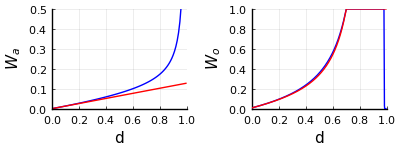

In [5]:
Nthresh = 50
p = plot(layout=(1,2), xlim=(0,1), size=(400,150), legend=:none)

plot!(p[1], ylim=(0,0.5), xlab=:d, ylab=L"W_a")
plot!(p[1], 0:0.01:1., d -> Turnover.W_orphaned( d; N= Nthresh*(1-d) ),c=:blue)
plot!(p[1], 0:0.01:1., d -> Turnover.W_orphaned( d; N= Nthresh ), lab=:none, c=:red)

mu =  mu

plot!(p[2], ylim=(0,1), xlab=:d, ylab=L"W_o")
plot!(p[2], 0:0.0001:1, d -> min(1., W_estranged(d ; b=1., μ=mu, T=log(Nthresh*(1-d ))/(1-d ))),c=:blue)
plot!(p[2], 0:0.0001:1, d -> min(1., W_estranged(d ; b=1., μ=mu, T=log(Nthresh)/(1-d ))), c=:red)

In [13]:
samplesize = 500
Nthresh = 500

500

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


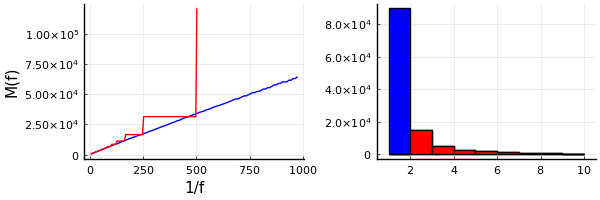

In [8]:
f_whole = Float64[]
f_sample = Float64[]
counts_all = Int[]
counts_pass = Int[]
@showprogress for row in eachrow(tumorinfo)
    t = row.tumor
    append!(f_whole, TumorGrowth.mutation_freqs(t).frequency)
    tumorsample = t[sample(1:nrow(t), samplesize, replace=false), :]
    seq = TumorGrowth.mutation_freqs(tumorsample)
    append!(f_sample, seq.frequency)
    append!(counts_all, seq.reads)
    append!(counts_pass, seq.reads[seq.frequency .> 1/Nthresh])
end
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_whole, res=res, c=:blue)
    M!(p[1], f_sample, c=:red, res=res)
    histogram!(p[2], counts_all, bins=1:10, c=:blue)
    histogram!(p[2], counts_pass, bins=1:10, c=:red)
end

> whole tumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


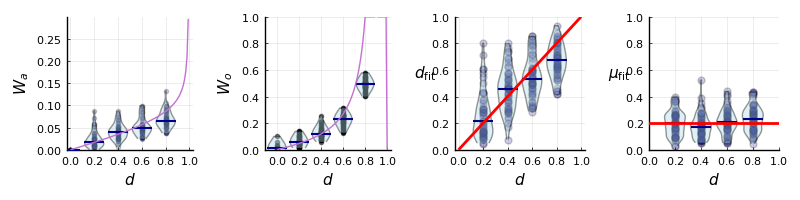

In [45]:
ds, Wa, Wo = get_turnover(tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh)
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

> sample

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


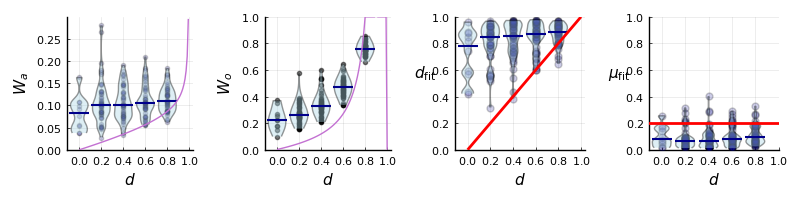

In [38]:
ds, Wa, Wo = get_turnover(tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh,
    tumor_sample_func = df -> df[sample(1:nrow(df), samplesize, replace=false), :])
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

In [70]:
Nthresh = 100

100

> whole tumor

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


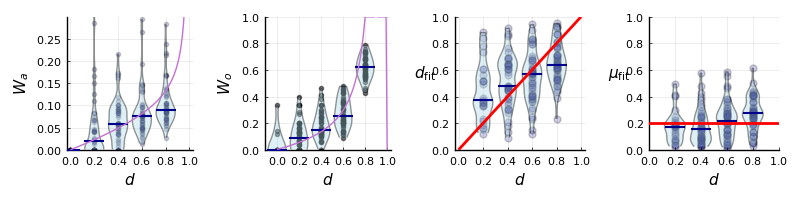

In [43]:
ds, Wa, Wo = get_turnover(tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh)
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

> sample

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


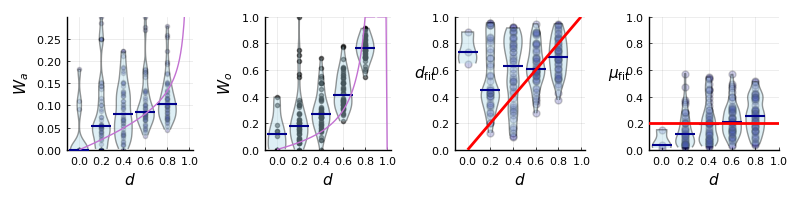

In [48]:
ds, Wa, Wo = get_turnover(tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh,
    tumor_sample_func = df -> df[sample(1:nrow(df), samplesize, replace=false), :])
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


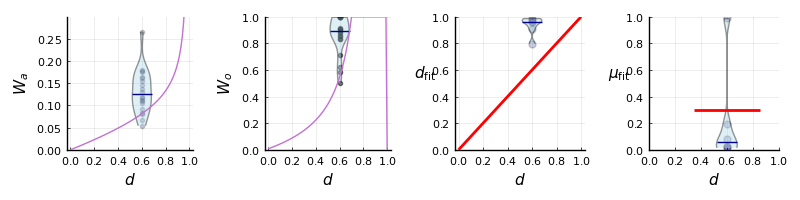

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [80]:
ds, Wa, Wo = get_turnover(tumorinfo; f_min = 50,
    tumor_sample_func = df -> begin
        df = TumorGrowth.cross_section(df, x=mean(df.position)[1], width=2, reduce_dim=true)
        df[sample(1:nrow(df), 500, replace=false), :]
    end)
ds, dfits, mufits = infer_params( tumorinfo; N = 0, estimate_N = true, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

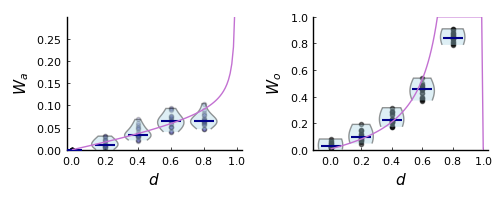

In [143]:
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=mu, size=(500,200),
    usecorrection=true, grid=false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


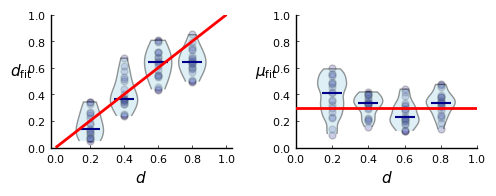

In [146]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, Wa, Wo,
    usecorrection=true)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200), grid=false)
savefig("inference_result.pdf")

### use known tumor size `N` at birth

In [145]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph * (1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr * (1-d_solve/b) )/(b-d_solve)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

In [59]:
Nthresh_orph , Nthresh_estr = 1000, 1000
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df)
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask];

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


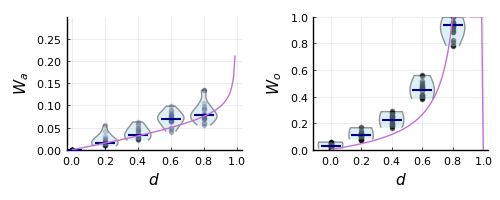

In [60]:
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200), 
    usecorrection=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


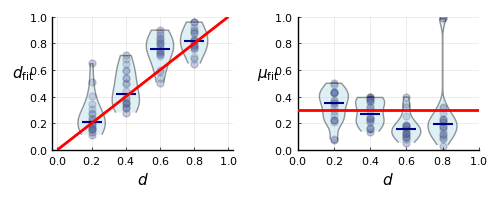

In [61]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo, 
    usecorrection=true)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


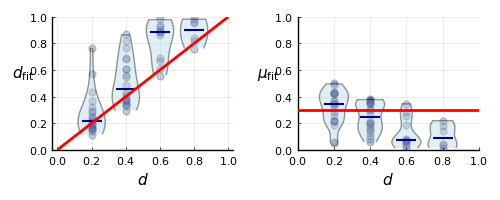

In [62]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo, 
    usecorrection=false)
mask = .!ismissing.(mufits)
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

In [65]:
Nthresh_orph , Nthresh_estr = 7000, 7000
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


(ds = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8], Wa = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.07808678837513508, 0.061224489795918366, 0.04792392786785877, 0.05398663277793467, 0.045124899274778404, 0.06000962721292186, 0.047696729589062375, 0.05068765064511555, 0.05520546729386704, 0.06058154689676869], Wo = [0.04242424242424243, 0.03443187407771766, 0.02212138400453772, 0.025393600812595226, 0.0387906446092413, 0.02830188679245283, 0.03613744075829384, 0.026203208556149733, 0.029315960912052116, 0.03561643835616438  …  0.8207739307535644, 0.8383838383838385, 0.7864693446088797, 0.7927565392354126, 0.832258064516129, 0.8093306288032455, 0.8217821782178221, 0.8119834710743804, 0.7675781250000004, 0.7718631178707225])

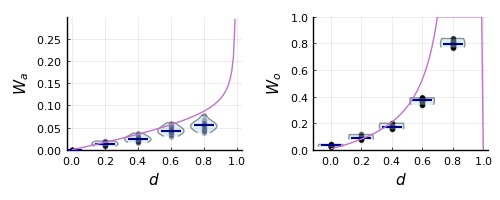

In [64]:
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh, Nthresh_estr=Nthresh, mu=mu, size=(500,200),
    usecorrection=true)

### use known time `T` at birth

In [152]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph * (1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr * (1-d_solve/b) )/(b-d_solve)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

In [70]:
Nthresh_orph , Nthresh_estr = 500, 500
ds, Wa, Wo = get_turnover(tumorinfo; useknown_T = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


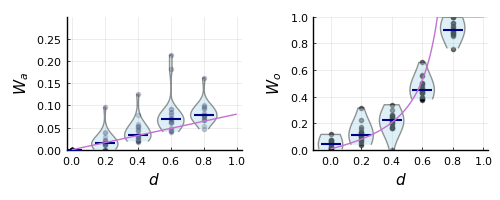

In [72]:
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu, size=(500,200), 
    usecorrection = false)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


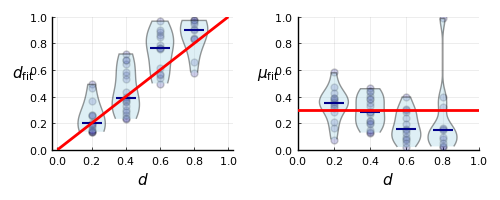

In [73]:
ds, dfits, mufits = infer_params( tumorinfo[mask,:]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=false)
mask_fit = .!ismissing.(mufits)
plot_infresult_violin(ds[mask_fit], dfits[mask_fit], mufits[mask_fit]; mu=mu, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


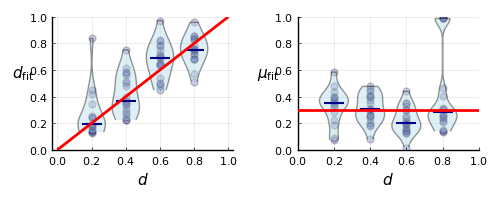

In [74]:
ds, dfits, mufits = infer_params( tumorinfo[mask,:]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=true)
mask_fit = .!ismissing.(mufits)
plot_infresult_violin(ds[mask_fit], dfits[mask_fit], mufits[mask_fit]; mu=mu, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


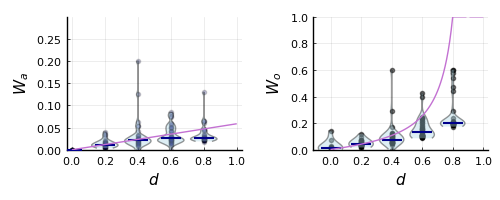

In [52]:
Nthresh_orph , Nthresh_estr = 5000, 5000
ds, Wa, Wo = get_turnover(tumorinfo; useknown_T = true, Nthresh_orph, Nthresh_estr,
    tumor_sample_func = df -> df)
mask = .!(isnan.(Wo))
ds, Wa, Wo = ds[mask], Wa[mask], Wo[mask]
plot_turnover_violin(ds, Wa, Wo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

# Spatial sampling

In [101]:
f_whole = Float64[]
f_sample = Float64[]
counts_all = Int[]
counts_pass = Int[]
@showprogress for row in eachrow(tumorinfo)
    t = row.tumor
    seq_whole = TumorGrowth.mutation_freqs(t)
    append!(f_whole, seq_whole.frequency)
    samples, tumorsample = TumorGrowth.multi_region_sequencing(t; samplingparams...)
    for row in eachrow(tumorsample)
        mask = row.frequencies .> samplecutoff
        row.mutations, row.frequencies = row.mutations[mask], row.frequencies[mask]
    end
    seq = TumorGrowth.sampletumor_mfreqs(tumorsample)
    append!(f_sample, seq.frequency)
    muts = seq.mutation[seq.frequency .> 1/Nthresh_orph]
    append!(counts_all, filter(r->r.mutation in muts, seq_whole).reads)
    append!(counts_pass, [count(s -> m in s, tumorsample.mutations ) for m in muts])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


In [125]:
Nthresh_orph, Nthresh_estr, samplecutoff= 500,500, 1/5
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(500, 500, 0.2)
(n = 280, cells_per_sample = 20)


2430

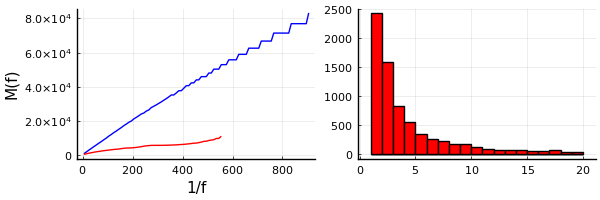

In [96]:
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_whole, res=res, c=:blue)
    M!(p[1], f_sample, c=:red, res=res)
    print(count(isequal(1), counts_pass))
    histogram!(p[2], counts_all, bins=1:20, c=:blue)
    histogram!(p[2], counts_pass, bins=1:20, c=:red)
end

In [124]:
Nthresh_orph, Nthresh_estr, samplecutoff= 200,200, 1/2
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(200, 200, 0.5)
(n = 280, cells_per_sample = 20)


0

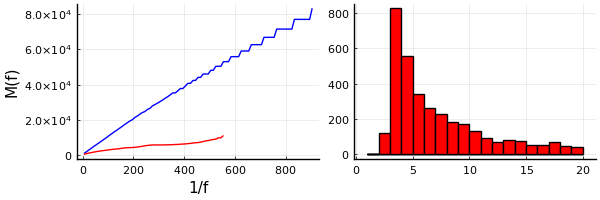

In [93]:
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_whole, res=res, c=:blue)
    M!(p[1], f_sample, c=:red, res=res)
    print(count(isequal(1), counts_pass))
    histogram!(p[2], counts_all, bins=1:20, c=:blue)
    histogram!(p[2], counts_pass, bins=1:20, c=:red)
end

In [123]:
Nthresh_orph, Nthresh_estr, samplecutoff= 500,500, 1/4
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(500, 500, 0.25)
(n = 280, cells_per_sample = 20)


400

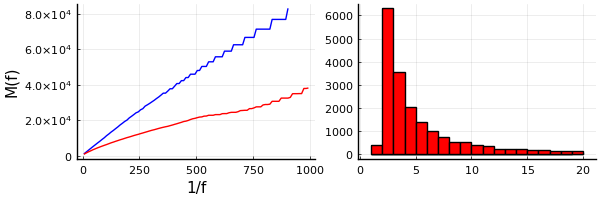

In [99]:
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_whole, res=res, c=:blue)
    M!(p[1], f_sample, c=:red, res=res)
    print(count(isequal(1), counts_pass))
    histogram!(p[2], counts_all, bins=1:20, c=:blue)
    histogram!(p[2], counts_pass, bins=1:20, c=:red)
end

In [122]:
Nthresh_orph, Nthresh_estr, samplecutoff= 200,200, 1/4
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(200, 200, 0.25)
(n = 280, cells_per_sample = 20)


0

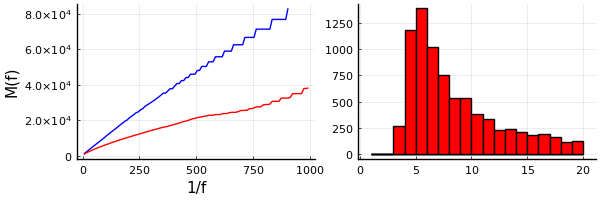

In [102]:
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_whole, res=res, c=:blue)
    M!(p[1], f_sample, c=:red, res=res)
    print(count(isequal(1), counts_pass))
    histogram!(p[2], counts_all, bins=1:20, c=:blue)
    histogram!(p[2], counts_pass, bins=1:20, c=:red)
end

0

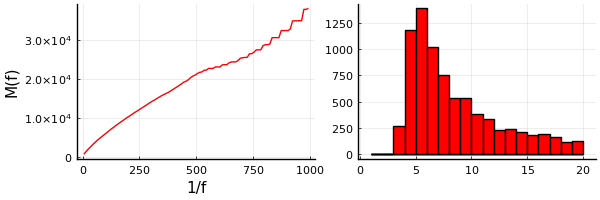

In [103]:
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_sample, c=:red, res=res)
    print(count(isequal(1), counts_pass))
    histogram!(p[2], counts_all, bins=1:20, c=:blue)
    histogram!(p[2], counts_pass, bins=1:20, c=:red)
end

In [19]:
ds, Wa, Wo = get_turnover(tumorinfo;
    Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr,
    tumor_sample_func = df -> begin
        samples, sampletumor = TumorGrowth.multi_region_sequencing(df; samplingparams...)
        for row in eachrow(sampletumor)
            mask = row.frequencies .> samplecutoff
            row.mutations, row.frequencies = row.mutations[mask], row.frequencies[mask]
        end
        sampletumor
    end,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,
#     subsample_func = df -> SeqDataFormatting.subsample(df; nmuts = 30, cols=[:mutations])
    
);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


In [121]:
Nthresh_orph, Nthresh_estr, samplecutoff= 500,500, 1/2
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(500, 500, 0.5)
(n = 280, cells_per_sample = 20)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


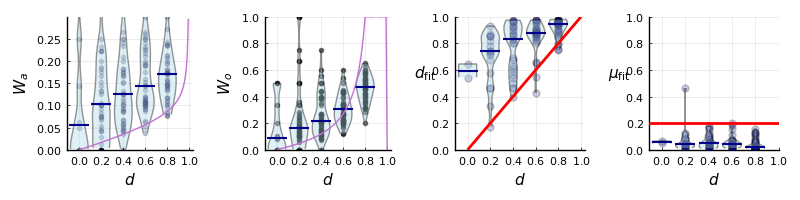

In [106]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

In [120]:
Nthresh_orph, Nthresh_estr, samplecutoff= 200,200, 1/2
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(200, 200, 0.5)
(n = 280, cells_per_sample = 20)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


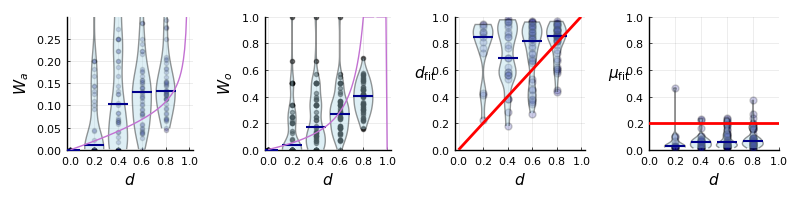

In [109]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

In [18]:
Nthresh_orph, Nthresh_estr, samplecutoff= 500,500, 1/3
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(500, 500, 0.3333333333333333)
(n = 280, cells_per_sample = 20)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


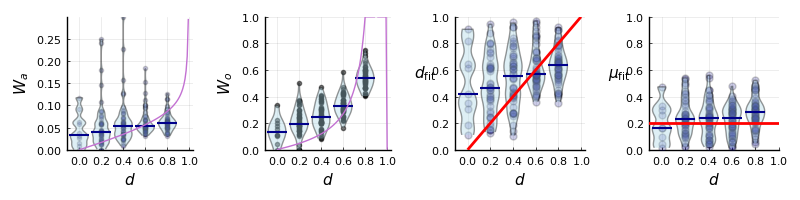

In [25]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

In [11]:
Nthresh_orph, Nthresh_estr, samplecutoff= 200,200, 1/3
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(200, 200, 0.3333333333333333)
(n = 280, cells_per_sample = 20)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


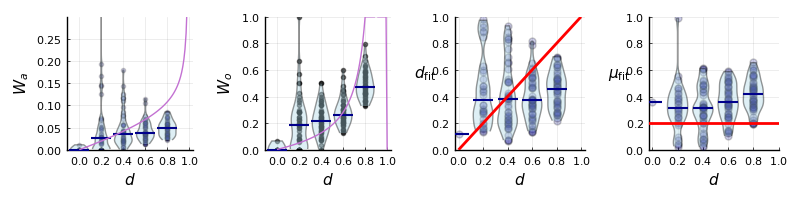

In [17]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

In [119]:
Nthresh_orph, Nthresh_estr, samplecutoff= 500,500, 1/4
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(500, 500, 0.25)
(n = 280, cells_per_sample = 20)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


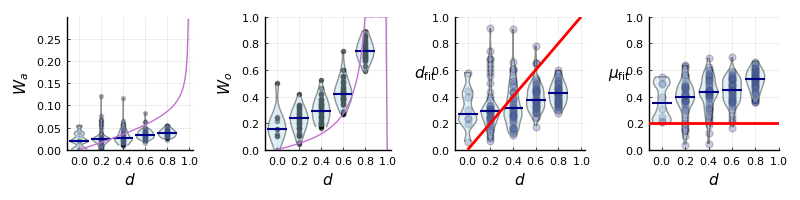

In [112]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

In [118]:
Nthresh_orph, Nthresh_estr, samplecutoff= 200,200, 1/4
println( (Nthresh_orph, Nthresh_estr, samplecutoff) )
samplingparams = (n = 280, cells_per_sample = 20)
println( samplingparams )

(200, 200, 0.25)
(n = 280, cells_per_sample = 20)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


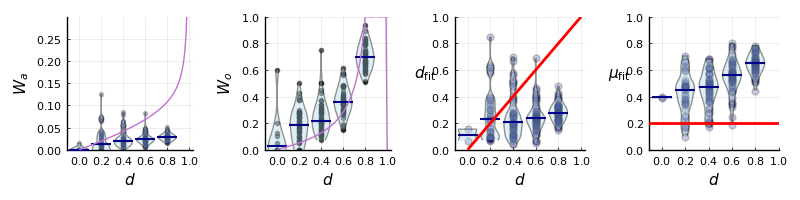

In [115]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo,
    usecorrection=true)
mask_turnover = @. !isnan(Wa) * !isnan(Wo)
mask_inference = @. !ismissing(mufits)

plot( layout=(1,2), size=(800,200),
    plot_turnover_violin(ds[mask_turnover], Wa[mask_turnover], Wo[mask_turnover]; 
        Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu,
        usecorrection=true),
    plot_infresult_violin(ds[mask_inference], dfits[mask_inference], mufits[mask_inference]; mu=mu)
    )

In [101]:
# scaleby = 1 / ( samplecutoff * samplingparams.n * samplingparams.cells_per_sample / 10_000 )

### use samplefrequency

In [156]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph/(1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr/(1-d_solve/b)) / (b-d_solve)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

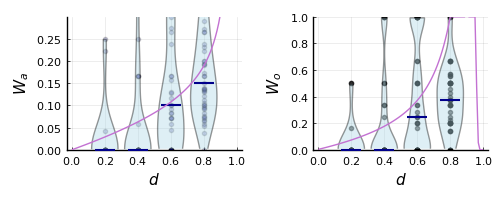

In [108]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask];
    Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu, size=(500,200),
    usecorrection=true)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


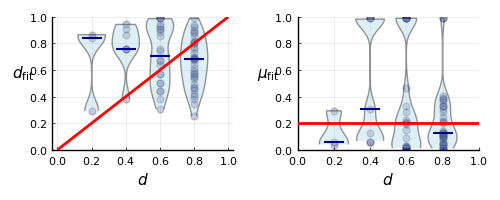

In [109]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200),
    usecorrection=true)

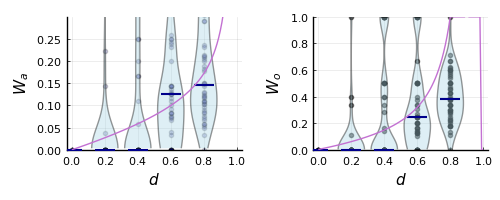

In [99]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask];
    Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=mu, size=(500,200),
    usecorrection=true)

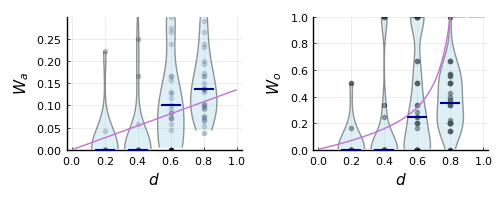

In [105]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


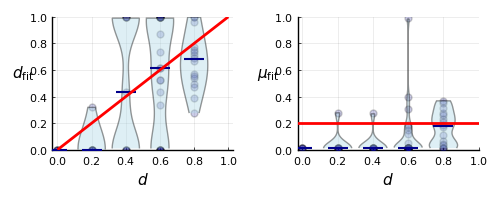

In [113]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

> Nthresh_orph, Nthresh_estr, samplecutoff= 40, 20, 1/2 <br>
> samplingparams = (n = 285, cells_per_sample = 20)

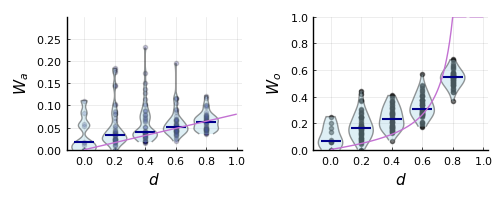

In [157]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

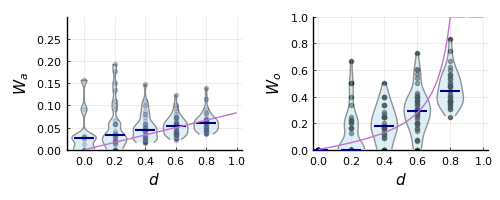

In [154]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


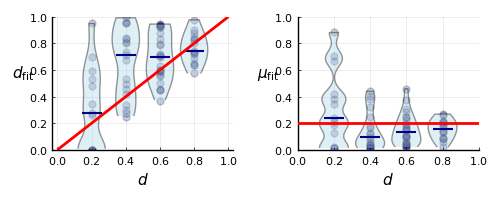

In [158]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph = Nthresh_orph_infer, Nthresh_estr = Nthresh_estr_infer, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

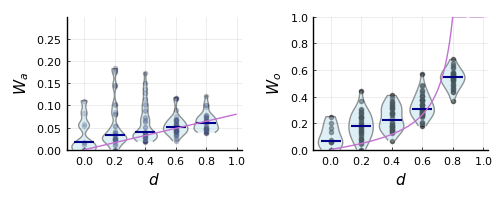

In [68]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


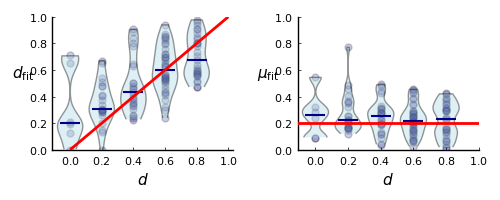

In [23]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200), grid=:off)

In [ ]:
# savefig(projectdir*"Turnover/turnover_plots/inference/inference_spatial_sampling_N500_n285_inference_violin.pdf")
# savefig(projectdir*"Turnover/turnover_plots/inference/inference_spatial_sampling_N500_n285_inference_violin.png")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


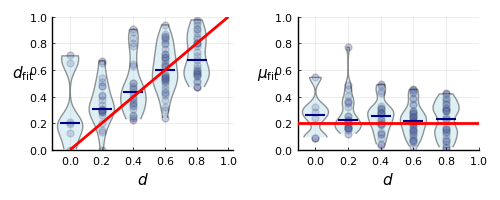

In [70]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


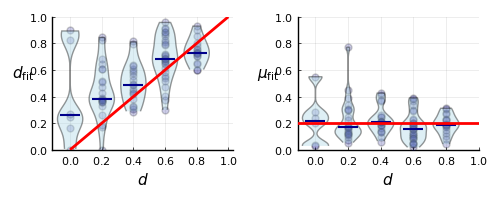

In [63]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph * scaleby, Nthresh_estr=Nthresh_estr *scaleby, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


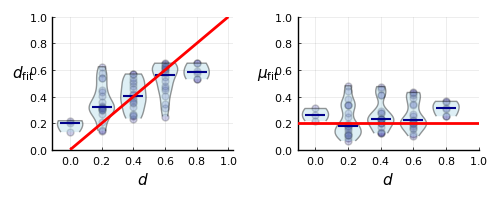

In [19]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


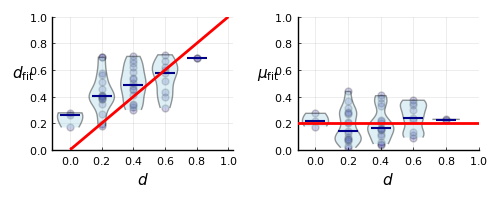

In [64]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh_orph * scaleby, Nthresh_estr=Nthresh_estr *scaleby, Wa, Wo)
mask = [!ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits,mufits)]
p = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

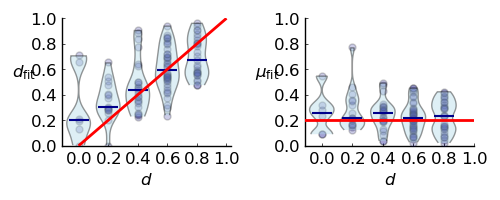

In [77]:
let data = include("turnover_data/inference_spatialdata_results.jl")[end]
    ds_, dfits_, mufits_ = data.ds, data.dfits, data.mufits
    mask = .!ismissing.(mufits_)
    plot_infresult_violin(ds_[mask], dfits_[mask], mufits_[mask]; mu=0.2, size=(500,200))
    plot!( size=(500,200), xlab=L"d", grid=false, guidefont = (12), tickfont = (12), legendfont=(12))
end

In [83]:
# savefig("Turnover/turnover_plots/inference/inference_spatial_N500_n285_mu_violin_defence.png")

> Nthresh_orph, Nthresh_estr, samplecutoff= 500, 500, 1/3 <br>
> samplingparams = (n = 285, cells_per_sample = 20)

### use known tumor size `N` at birth

In [78]:
function infer_params_Ncorrect( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
    dfits = []
    mufits = []

    @showprogress for i in 1:nrow(tumorinfo)
        b, mu = tumorinfo.b[i], tumorinfo.μ[i]
        W_a, W_o = Wa[i], Wo[i]
        
        d_solve, mu_solve = 1., missing
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= Nthresh_orph*(1-x) )) - W_a, 0.01, 0.99) * b
            mu_solve = fzero(x -> min(1., Turnover.W_estranged(d_solve; b=b, μ=x, 
                            T=log(Nthresh_estr/b)))- W_o, 0.01, 0.99)
            catch e
        end

        push!(dfits, d_solve)
        push!(mufits, mu_solve)

        sleep(0.01)
    end
    return (ds = tumorinfo.d, dfits = dfits, mufits = mufits)
end

infer_params_Ncorrect (generic function with 1 method)

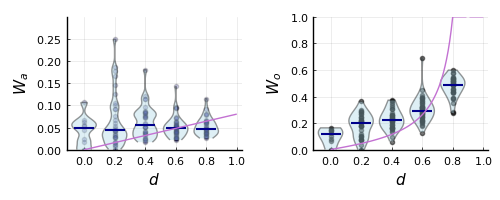

In [80]:
mask = @. !isnan(Wo) * !isnan(Wa)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


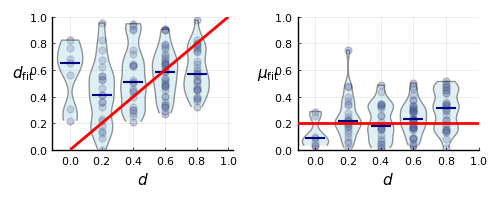

In [84]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


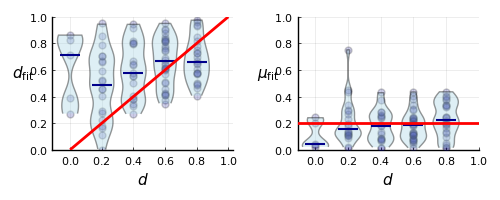

In [85]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph=Nthresh_orph*scaleby, Nthresh_estr=Nthresh_estr*scaleby, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


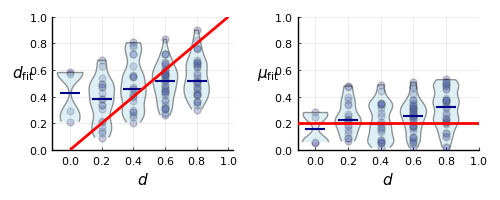

In [87]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


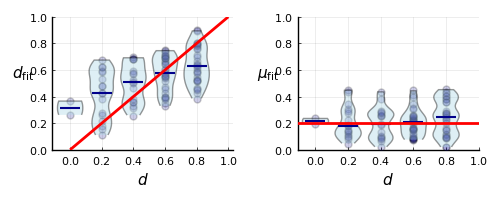

In [88]:
ds, dfits, mufits = infer_params_Ncorrect( tumorinfo; Nthresh_orph=Nthresh_orph*scaleby, Nthresh_estr=Nthresh_estr*scaleby, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

### use known time `T` at birth

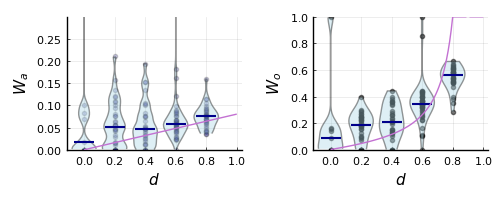

In [22]:
mask = .!isnan.(Wo)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


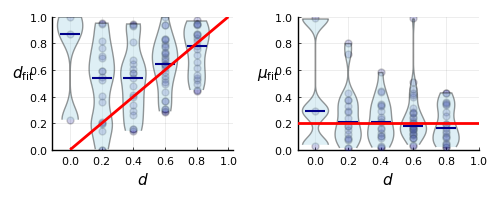

In [23]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))

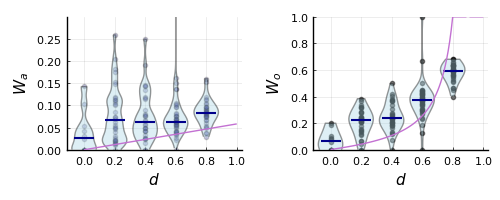

In [72]:
mask = .!isnan.(Wo)
plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; Nthresh_orph=Nthresh_orph, Nthresh_estr=Nthresh_estr, mu=0.2, size=(500,200))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


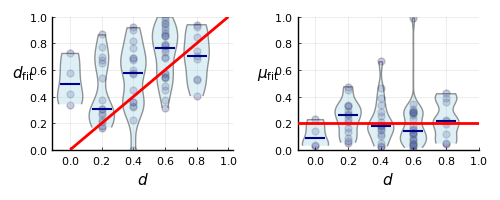

In [ ]:
ds, dfits, mufits = infer_params( tumorinfo; Nthresh_orph, Nthresh_estr, Wa, Wo)
mask = [ !ismissing(m) && !isnan(m) && !ismissing(d) && !isnan(d) for (d,m) in zip(dfits, mufits)]
plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=0.2, size=(500,200))